### Non-Local Means Comparison

The purpose of this notebook is to create a baseline similarity comparison between the low-level intensity images using non-local means image processing algorithm with the high intensity cell images.

Model repo: http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_nl_means
Paper: 

In [1]:
import numpy as np
import skimage 
import matplotlib.pyplot as plt

from cellvision_lib import train_test_val
from scipy.stats import entropy
from skimage import data, img_as_float, img_as_ubyte, io
from skimage.measure import compare_ssim
from skimage.measure import compare_mse
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import glob
import os

MAX_DEPTH = 100
NUM_SAMPLES = 109

folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'

# train, test, val = train_test_val(folder_path, channels = 1, train_pp = .67, test_pp = .165, val_pp = .165, set_seed = 1)

def get_comp_path_tuples(data_dir, comp_channel, reference_channel=6):
    comps = []
    for i in range(1, NUM_SAMPLES):
        for z in range(1, MAX_DEPTH):
            ref_path = data_dir + '/sample{}_channel{}_z{}.tif'.format(i, reference_channel, z)
            comp_path = data_dir + '/sample{}_channel{}_z{}.tif'.format(i, comp_channel, z)
            if not os.path.isfile(ref_path) or not os.path.isfile(comp_path):
                continue
            comps.append( (comp_path, ref_path) )
    return comps

channel1_comps = get_comp_path_tuples(folder_path, 1)
channel2_comps = get_comp_path_tuples(folder_path, 2)
channel3_comps = get_comp_path_tuples(folder_path, 3)
channel4_comps = get_comp_path_tuples(folder_path, 4)
channel5_comps = get_comp_path_tuples(folder_path, 5)

print(len(channel1_comps))

10488


In [14]:
# Channel 1 comps
import pickle as pkl
from time import time

def process_channel_comps(image_paths, channel, test=''):
    print()
    print("Beginning comp process for channel {}".format(channel))
    comps = []
    for comp_path, ref_path in image_paths:
        comp = io.imread(comp_path).astype(np.uint)
        ref = io.imread(ref_path).astype(np.uint)
        comp_ft = img_as_float(comp)
        ref_ft = img_as_float(ref)w
        channel_mse = compare_mse(comp, ref)
        _min = ref_ft.min()
        _max = ref_ft.max()
        channel_ssim = compare_ssim(comp_ft, ref_ft, data_range=_max-_min)
        denoised_comp = denoise_nl_means(comp_ft)
        channel_dn_mse = compare_mse(denoised_comp, ref_ft)
        channel_dn_ssim = compare_ssim(denoised_comp, ref_ft, data_range=_max-_min)
        comps.append( (comp_path, ref_path, channel_mse, channel_ssim, channel_dn_mse, channel_dn_ssim) )
    out_path = "outputs/baseline_channel{}{}".format(channel,test)
    print("Dumping pickled results into {}".format(out_path))
    pkl.dump(comps, open(out_path, "wb"))

start = time()
process_channel_comps(channel1_comps[0:300], 1, test='')
process_channel_comps(channel2_comps[0:300], 2, test='')
process_channel_comps(channel3_comps[0:300], 3, test='')
process_channel_comps(channel4_comps[0:300], 4, test='')
process_channel_comps(channel5_comps[0:300], 5, test='')
end = time()
print("Elapsed time: {} seconds".format(round(end - start, 2)))


Beginning comp process for channel 1
Dumping pickled results into outputs/baseline_channel1

Beginning comp process for channel 2
Dumping pickled results into outputs/baseline_channel2

Beginning comp process for channel 3
Dumping pickled results into outputs/baseline_channel3

Beginning comp process for channel 4
Dumping pickled results into outputs/baseline_channel4

Beginning comp process for channel 5
Dumping pickled results into outputs/baseline_channel5
Elapsed time: 2711.28 seconds


In [15]:
channel_comps = []
load_channels = range(1,6)
for i in load_channels:  
    with open('outputs/baseline_channel{}'.format(i), 'rb') as pickle_file:
        channel_scores = pkl.load(pickle_file)
        channel_comps.append(channel_scores)

In [16]:
print(channel_comps[1][0])

('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel2_z1.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z1.tif', 20511113.88896942, 0.2965951636780404, 6.028695810753086e-32, 0.2985823346768401)


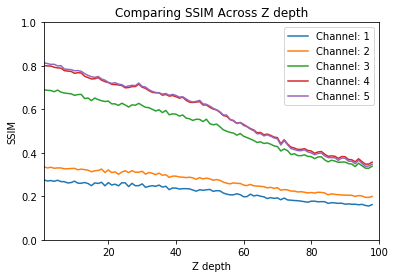

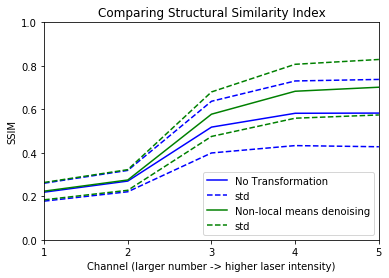

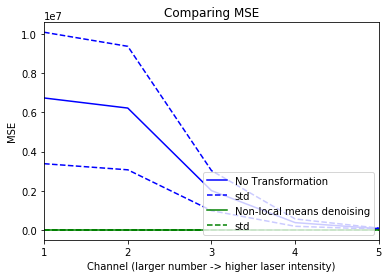

In [17]:
import statistics

z_means_idx2 = {}

metrics_tracker = {
    'z_means_idx' : {},
    'mse_means': [],
    'mse_stds' : [],
    'ssim_means' : [],
    'ssim_stds' : [],
    'mse_means_dn' : [],
    'mse_stds_dn' : [],
    'ssim_means_dn' : [],
    'ssim_stds_dn' : []
}

for i, channel in enumerate(channel_comps):
    mse = [metric[2] for metric in channel]
    mse_std = statistics.stdev(mse)
    mse_mean = statistics.mean(mse)
    metrics_tracker['mse_means'] = metrics_tracker['mse_means'] + [mse_mean]
    metrics_tracker['mse_stds'] = metrics_tracker['mse_stds'] + [mse_std]
    
    ssim = [metric[3] for metric in channel]
    ssim_std = statistics.stdev(ssim)
    ssim_mean = statistics.mean(ssim)
    metrics_tracker['ssim_means'] = metrics_tracker['ssim_means'] + [ssim_mean]
    metrics_tracker['ssim_stds'] = metrics_tracker['ssim_stds'] + [ssim_std]
    
    mse_dn = [metric[4] for metric in channel]
    mse_dn_std = statistics.stdev(mse_dn)
    mse_dn_mean = statistics.mean(mse_dn)
    metrics_tracker['mse_means_dn'] = metrics_tracker['mse_means_dn'] + [mse_dn_mean]
    metrics_tracker['mse_stds_dn'] = metrics_tracker['mse_stds_dn'] + [mse_dn_std]
    
    ssim_dn = [metric[5] for metric in channel]
    ssim_dn_std = statistics.stdev(ssim_dn)
    ssim_dn_mean = statistics.mean(ssim_dn)
    metrics_tracker['ssim_means_dn'] = metrics_tracker['ssim_means_dn'] + [ssim_dn_mean]
    metrics_tracker['ssim_stds_dn'] = metrics_tracker['ssim_stds_dn'] + [ssim_dn_std]
    
#     z_means_idx2 = {}
    for metric in channel:
        z_idx = metric[0].find('_z')
        z_val = metric[0][z_idx + 2:-4]
        key = str(i + 1) + '_' + str(z_val)
        if key not in z_means_idx2:
            z_means_idx2[key] = [metric[3]]
        else:
            z_means_idx2[key] = z_means_idx2[key] + [metric[3]]

for key, val in z_means_idx2.items():
    z_means_idx2[key] = statistics.mean(val)
# print(z_means_idx2)
# print(metrics_tracker)
# Comparing Structural Similarity Index for denoising
MAX_DEPTH = 99
for i in range(1,6):
    channel_z_means = []
    for y in range(1,MAX_DEPTH):
        key = str(i) + '_' + str(y)
        channel_z_means.append(z_means_idx2[key])
    plt.plot(list(range(1, MAX_DEPTH)), channel_z_means, label="Channel: {}".format(i)) 

plt.title('Comparing SSIM Across Z depth')
plt.legend(loc = 'upper right')
plt.ylim([0, 1])
plt.xlim([1, 100])
# plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Z depth')
plt.show()
# print(z_means_idx.keys())
# print(z_means_idx['5_30'])   


# Comparing Structural Similarity Index for denoising
plt.plot(list(range(1, 6)), metrics_tracker['ssim_means'], label="No Transformation", color='blue') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['ssim_means'], metrics_tracker['ssim_stds'])], 
         label="std",
         linestyle='--',
         color='blue') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['ssim_means'], metrics_tracker['ssim_stds'])], 
         linestyle='--',
         color='blue') 

plt.plot(list(range(1, 6)), metrics_tracker['ssim_means_dn'], label="Non-local means denoising", color='green') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['ssim_means_dn'], metrics_tracker['ssim_stds_dn'])], 
         label="std",
         linestyle='--',
         color='green') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['ssim_means_dn'], metrics_tracker['ssim_stds_dn'])], 
         linestyle='--',
         color='green') 

plt.title('Comparing Structural Similarity Index')
plt.legend(loc = 'lower right')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

# Comparing MSE for denoising
plt.plot(list(range(1, 6)), metrics_tracker['mse_means'], label="No Transformation", color='blue') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['mse_means'], metrics_tracker['mse_stds'])], 
         label="std",
         linestyle='--',
         color='blue') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['mse_means'], metrics_tracker['mse_stds'])], 
         linestyle='--',
         color='blue') 

plt.plot(list(range(1, 6)), metrics_tracker['mse_means_dn'], label="Non-local means denoising", color='green') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['mse_means_dn'], metrics_tracker['mse_stds_dn'])], 
         label="std",
         linestyle='--',
         color='green') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['mse_means_dn'], metrics_tracker['mse_stds_dn'])], 
         linestyle='--',
         color='green') 

plt.title('Comparing MSE')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('MSE')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()
    


In [ ]:
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009/test data_1_MMStack_Undefined1.ome.tif'
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample28_channel1_z12.tif'
imsk = io.imread(path_to_data)
imsk.shape

In [ ]:
# Convert everything to scaled floating values
scaled_imgs_1 = []
scaled_imgs_2 = []
scaled_imgs_3 = []
scaled_imgs_4 = []
scaled_imgs_5 = []
scaled_imgs_6 = []
for i in range(0,imsk.shape[0], 7):
    scaled_imgs_1.append(img_as_float(imsk[i,:,:].astype(np.uint)))
    scaled_imgs_2.append(img_as_float(imsk[i+1,:,:].astype(np.uint)))
    scaled_imgs_3.append(img_as_float(imsk[i+2,:,:].astype(np.uint)))
    scaled_imgs_4.append(img_as_float(imsk[i+3,:,:].astype(np.uint)))
    scaled_imgs_5.append(img_as_float(imsk[i+4,:,:].astype(np.uint)))
    scaled_imgs_6.append(img_as_float(imsk[i+5,:,:].astype(np.uint)))
print(scaled_imgs_1[0])
# print(scaled_imgs_2[0])

In [ ]:
# for i in range(0,20,10):
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
ax[0].imshow(scaled_imgs_1[0]);
ax[0].axis('off')
ax[1].imshow(scaled_imgs_2[0]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs_3[0]);
ax[2].axis('off')
ax[3].imshow(scaled_imgs_4[0]);
ax[3].axis('off')
ax[4].imshow(scaled_imgs_6[0]);
ax[4].axis('off')
plt.title('z = '+str(1))
plt.show()

In [ ]:
_min = scaled_imgs[5].min()
_max = scaled_imgs[5].max()
print(ssim(scaled_imgs[0],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[1],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[2],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[3],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[4],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[5],scaled_imgs[5],data_range=_max-_min))
print(len(scaled_imgs))

In [ ]:
print(len(scaled_imgs_4))

In [ ]:
denoised_imgs_1 = []
denoised_imgs_2 = []
denoised_imgs_3 = []
denoised_imgs_4 = []
denoised_imgs_5 = []
denoised_imgs_6 = []
for i in range(0,5):
    denoised_imgs_1.append(denoise_nl_means(scaled_imgs_1[i]))
    denoised_imgs_2.append(denoise_nl_means(scaled_imgs_2[i]))
    denoised_imgs_3.append(denoise_nl_means(scaled_imgs_3[i]))
    denoised_imgs_4.append(denoise_nl_means(scaled_imgs_4[i]))
    denoised_imgs_5.append(denoise_nl_means(scaled_imgs_5[i]))
    denoised_imgs_6.append(denoise_nl_means(scaled_imgs_6[i]))
    print(i)
print(denoised_imgs_1[0])

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(scaled_imgs_1[0]);
ax[0].axis('off')
ax[1].imshow(denoised_imgs_1[0]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs_5[0]);
ax[2].axis('off')
ax[3].imshow(denoised_imgs_5[0]);
ax[3].axis('off')
plt.title('z = '+str(1))
plt.show()

print(ssim(denoised_imgs_4[0],scaled_imgs_5[0],data_range=_max-_min))

In [ ]:
original_ssim_1 = []
nl_ssim_1 = []
for i in range(0,5):
    _min = scaled_imgs_6[i].min()
    _max = scaled_imgs_6[i].max()
    original_ssim_1.append(ssim(scaled_imgs_1[i],scaled_imgs_6[i],data_range=_max-_min))
    nl_ssim_1.append(ssim(denoised_imgs_1[i],scaled_imgs_6[i],data_range=_max-_min))
    
print(sum(original_ssim_1)/len(original_ssim_1))
print(sum(nl_ssim_1)/len(nl_ssim_1))

original_ssim_4 = []
nl_ssim_4 = []
for i in range(0,5):
    _min = scaled_imgs_6[i].min()
    _max = scaled_imgs_6[i].max()
    original_ssim_4.append(ssim(scaled_imgs_4[i],scaled_imgs_6[i],data_range=_max-_min))
    nl_ssim_4.append(ssim(denoised_imgs_4[i],scaled_imgs_6[i],data_range=_max-_min))
    
print(sum(original_ssim_4)/len(original_ssim_4))
print(sum(nl_ssim_4)/len(nl_ssim_4))

# plt.plot(list(range(0, 5)), original_ssim, label="No change") 
# plt.plot(list(range(0, 5)), nl_ssim, label="Non-local means denoising") 

# plt.title('Comparing Structural Similarity Index')
# plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
# plt.xlim([0, 4])
# plt.axes().set_xticks(list(range(0, 5)), minor=False)

# plt.ylabel('SSIM')
# plt.xlabel('Laser Intensity')
# plt.show()

    
    

In [ ]:
print(sum(original_ssim_1)/len(original_ssim_1))
print(sum(nl_ssim_1)/len(nl_ssim_1))